In [2]:
from bs4 import BeautifulSoup
import requests
from urllib.parse import urljoin
import trafilatura

def scrape_website(url):
    """
    Scrape text, image URLs, audio URLs, and tables from a website
    Returns: (text_content, image_urls, audio_urls, tables)
    """
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'html.parser')
        
        # Extract main text content using trafilatura
        downloaded = trafilatura.fetch_url(url)
        text_content = trafilatura.extract(downloaded, include_links=True)
        if text_content is None:
            text_content = soup.get_text(separator=' ', strip=True)
            
        # Extract image URLs
        image_urls = []
        for img in soup.find_all('img'):
            src = img.get('src')
            if src:
                absolute_url = urljoin(url, src)
                if absolute_url.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.webp')):
                    image_urls.append(absolute_url)
        
        # # Extract audio URLs
        # audio_urls = []
        # audio_tags = soup.find_all(['audio', 'a'])
        # for tag in audio_tags:
        #     if tag.name == 'audio':
        #         sources = tag.find_all('source')
        #         for source in sources:
        #             src = source.get('src')
        #             if src:
        #                 absolute_url = urljoin(url, src)
        #                 if absolute_url.lower().endswith(('.mp3', '.wav', '.ogg', '.m4a')):
        #                     audio_urls.append(absolute_url)
        #     elif tag.name == 'a':
        #         href = tag.get('href')
        #         if href:
        #             absolute_url = urljoin(url, href)
        #             if absolute_url.lower().endswith(('.mp3', '.wav', '.ogg', '.m4a')):
        #                 audio_urls.append(absolute_url)
        
        # Extract tables
        tables = []
        for table in soup.find_all('table'):
            # Extract table data into a list of dictionaries
            table_data = []
            headers = []
            
            # Get headers (th cells)
            header_row = table.find('tr')
            if header_row:
                for th in header_row.find_all(['th', 'td']):
                    headers.append(th.get_text(strip=True))
            
            # Get table rows
            for row in table.find_all('tr')[1:]:  # Skip header row if we found one
                cells = row.find_all(['td', 'th'])
                if cells:
                    row_data = {}
                    for i, cell in enumerate(cells):
                        header = headers[i] if i < len(headers) else f'Column_{i}'
                        row_data[header] = cell.get_text(strip=True)
                    table_data.append(row_data)
            
            if table_data:
                tables.append(table_data)
        
        return text_content, image_urls,  tables
    
    except Exception as e:
        print(f"Error scraping {url}: {str(e)}")
        return None, [], [], []

In [15]:
url = "https://en.wikipedia.org/wiki/Cosmos"
text_content, image_urls,  tables = scrape_website(url)

In [10]:
print("Text Content:", text_content[:100], "...")

print("lenght of text files found:", len(text_content))


print("Image URLs:", image_urls)
print("Number of images found:", len(image_urls))
print("Tables:", tables)
print("Number of tables found:", len(tables))

Text Content: Cosmos
The cosmos ([/ˈkɒzmɒs/](/wiki/Help:IPA/English), [US](/wiki/American_English) also [/-moʊs, - ...
lenght of text files found: 40599
Image URLs: ['https://en.wikipedia.org/static/images/icons/wikipedia.png', 'https://upload.wikimedia.org/wikipedia/commons/thumb/8/87/Flammarion.jpg/265px-Flammarion.jpg', 'https://upload.wikimedia.org/wikipedia/commons/thumb/1/15/The_Nights_Long_Moments_%28152181573%29.jpeg/220px-The_Nights_Long_Moments_%28152181573%29.jpeg', 'https://upload.wikimedia.org/wikipedia/commons/thumb/7/78/Copernicus_-_Heliocentric_Solar_System.JPG/220px-Copernicus_-_Heliocentric_Solar_System.JPG', 'https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Ptolemaicsystem-small.png/250px-Ptolemaicsystem-small.png', 'https://upload.wikimedia.org/wikipedia/commons/thumb/d/d7/Philolaus-and-Philomelus-Pythagorean-Book.jpg/250px-Philolaus-and-Philomelus-Pythagorean-Book.jpg', 'https://upload.wikimedia.org/wikipedia/commons/thumb/f/fa/Wikiquote-logo.svg/34px-Wiki

In [14]:
import re
import string
import spacy
from nltk.corpus import stopwords

# Load spaCy model and stop words
nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words('english'))

# Custom unwanted phrases
custom_unwanted_phrases = [
    "login", "sign up", "signup", "create account", "forgot password", 
    "click here", "read more", "terms of service", "privacy policy",
    "subscribe", "register", "next page", "previous page", "contact us",
    "about us", "home", "back to top", "follow us", "view more"
]

def preprocess_text(text):
    """
    Clean and preprocess text content, removing UI junk and <think> tags.
    No lemmatization is performed.
    """
    if not text:
        return ""

    # Remove <think>...</think> content
    text = re.sub(r'<think>.*?</think>', '', text, flags=re.DOTALL)

    # Remove newline characters and normalize whitespace
    text = re.sub(r'\s+', ' ', text.replace('\n', ' ').replace('\r', ' '))

    # Lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Remove unwanted UI phrases
    for phrase in custom_unwanted_phrases:
        text = text.replace(phrase, '')

    # Remove punctuation and digits
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenize with spaCy
    doc = nlp(text)
    tokens = [
        token.text for token in doc
        if token.text not in stop_words and token.text.strip() != ''
    ]

    return ' '.join(tokens)


In [17]:
text_content = preprocess_text(text_content)
print("Text Content:", text_content[:900], "...")


Text Content: cosmos cosmos ˈkɒzmɒswikihelpipaenglish uswikiamericanenglish also moʊs məswikihelpipaenglishcitenote ancient greekwikiancientgreeklanguage κόσμος romanizedwikiromanizationofancientgreek kósmos alternative name universewikiuniverse nature order usage word cosmos implies viewing universe complex orderly systemwikisystem entitycitenote cosmos studied cosmologywikicosmology – broad discipline covering scientific religious philosophical aspects cosmos nature religious philosophical approaches may include cosmos among spiritual entities matters deemed exist outside physical universe etymology editwindexphptitlecosmosactionedit§ion verb κοσμεῖν kosmein meant generally dispose prepare especially order arrange troops battle set army array also establish government regime adorn dress especially women thus kosmos meant ornaments decoration compare kosmokomes dressing hair cosmeticcitenote philosop ...


In [18]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.llms import Ollama

def generate_text_summaries(texts, tables, summarize_texts=False, model_name="mistral:latest"):
    """
    Summarize text elements using local Ollama models
    
    Args:
        texts: List of strings to summarize
        tables: List of table data strings
        summarize_texts: Whether to summarize texts (False returns originals)
        model_name: Which Ollama model to use ('deepseek-r1:14b' or 'mistral')
    
    Returns:
        tuple: (text_summaries, table_summaries)
    """
    # Initialize Ollama with your local model
    llm = Ollama(
        model=model_name,
        temperature=0.3,
        top_p=0.9,
        num_ctx=2048  # Context window size
    )
    
    # Optimized prompt for local models
    prompt_text = """[INST] <<SYS>>
    You are an AI assistant that creates concise, retrieval-optimized summaries.
    Keep summaries under 3 sentences while preserving key information.
    <</SYS>>
    
    Summarize this content for embedding-based retrieval:
    {element} [/INST]"""
    
    prompt = ChatPromptTemplate.from_template(prompt_text)
    summarize_chain = {"element": lambda x: x} | prompt | llm | StrOutputParser()

    # Process texts (conditionally summarize)
    text_summaries = texts
    if summarize_texts and texts:
        text_summaries = []
        for text in texts:
            # Batch processing with error handling
            try:
                summary = summarize_chain.invoke(text)
                text_summaries.append(summary)
            except Exception as e:
                print(f"Error summarizing text: {str(e)}")
                text_summaries.append(text[:500] + "...")  # Fallback

    # Process tables
    table_summaries = []
    if tables:
        for table in tables:
            try:
                summary = summarize_chain.invoke(f"TABLE DATA:\n{table}")
                table_summaries.append(summary)
            except Exception as e:
                print(f"Error summarizing table: {str(e)}")
                table_summaries.append(table)

    return text_summaries, table_summaries

In [19]:
text_content , table_summaries = generate_text_summaries(text_content, tables, summarize_texts=False)

/tmp/ipykernel_1821/4206370751.py:19: LangChainDeprecationWarning: The class `Ollama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaLLM``.
  llm = Ollama(


In [26]:
print("Table Summaries:", table_summaries[0][:200], "...")
print("table summaries length:", len(table_summaries[0]))

Table Summaries: 1. This table provides an overview of metaphysics, a branch of philosophy that explores fundamental questions about reality, existence, and the nature of being. It includes key theories (e.g., realism ...
table summaries length: 1068


In [27]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=250,
    length_function=len,
    add_start_index=True,
)

In [29]:
text_chunks = text_splitter.split_text(text_content)

In [ ]:
from torch import cuda
from langchain.embeddings.huggingface import HuggingFaceEmbeddings

embed_model_id = 'sentence-transformers/all-MiniLM-L6-v2'

device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'

embed_model = HuggingFaceEmbeddings(
    model_name=embed_model_id,
    model_kwargs={'device': device},
    encode_kwargs={'device': device},
)
retriever, original_docs  = create_multimodal_retriever(text_chunks=chunks,image_urls=image_urls, image_summaries=summaries["image_summaries"], tables=tables, table_summaries=summaries["table_summaries"], embed_model=embed_model)

/tmp/ipykernel_87246/831540564.py:8: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embed_model = HuggingFaceEmbeddings(


In [37]:
import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
import requests
import json

# Load CLIP model and processor
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")


# Helper: Embed text
def embed_text(text):
    # Truncate text to fit within the model's max_position_embeddings
    truncated_text = text[:clip_processor.tokenizer.model_max_length - 2]  # Account for special tokens
    inputs = clip_processor(text=[truncated_text], return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        embedding = clip_model.get_text_features(**inputs)
    return embedding[0].cpu().numpy()

# Helper: Embed image from URL
def embed_image_from_url(url):
    try:
        response = requests.get(url, stream=True, timeout=5)
        response.raise_for_status()  # Ensure valid response
        if 'image' not in response.headers.get("Content-Type", ""):
            raise ValueError(f"URL does not point to an image: {url}")
        
        img = Image.open(response.raw).convert("RGB")
        inputs = clip_processor(images=img, return_tensors="pt").to(device)
        with torch.no_grad():
            embedding = clip_model.get_image_features(**inputs)
        return embedding[0].cpu().numpy()
    
    except Exception as e:
        print(f"[ERROR] Could not process image URL: {url} → {e}")
        return None


# --- Get all embeddings ---




In [38]:
# 1. Embed text chunks
text_embeddings = [embed_text(text) for text in text_chunks]

# 2. Embed table summary (join list into a single string)
table_summary_embedding = embed_text(" ".join(table_summaries))

# 3. Embed full table (as JSON string)
table_json_embedding = embed_text(json.dumps(tables))

# 4. Embed images
image_embeddings = [embed_image_from_url(url) for url in image_urls]

[ERROR] Could not process image URL: https://upload.wikimedia.org/wikipedia/commons/thumb/1/15/The_Nights_Long_Moments_%28152181573%29.jpeg/220px-The_Nights_Long_Moments_%28152181573%29.jpeg → 403 Client Error: Forbidden. Please comply with the User-Agent policy: https://meta.wikimedia.org/wiki/User-Agent_policy for url: https://upload.wikimedia.org/wikipedia/commons/thumb/1/15/The_Nights_Long_Moments_%28152181573%29.jpeg/220px-The_Nights_Long_Moments_%28152181573%29.jpeg
[ERROR] Could not process image URL: https://upload.wikimedia.org/wikipedia/commons/thumb/7/78/Copernicus_-_Heliocentric_Solar_System.JPG/220px-Copernicus_-_Heliocentric_Solar_System.JPG → 403 Client Error: Forbidden. Please comply with the User-Agent policy: https://meta.wikimedia.org/wiki/User-Agent_policy for url: https://upload.wikimedia.org/wikipedia/commons/thumb/7/78/Copernicus_-_Heliocentric_Solar_System.JPG/220px-Copernicus_-_Heliocentric_Solar_System.JPG
[ERROR] Could not process image URL: https://upload.wi

/home/kelvin/miniconda3/envs/linux-deep-gpu/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


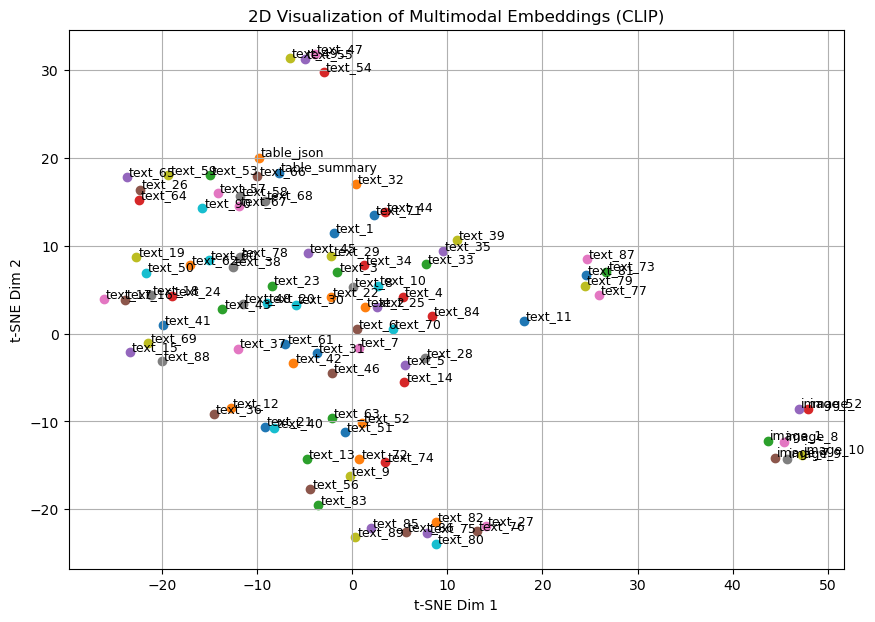

In [40]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Combine all embeddings into one list
all_embeddings = []
labels = []

# Text chunks
for i, emb in enumerate(text_embeddings):
    all_embeddings.append(emb)
    labels.append(f"text_{i+1}")

# Table summary
all_embeddings.append(table_summary_embedding)
labels.append("table_summary")

# Table JSON
all_embeddings.append(table_json_embedding)
labels.append("table_json")

# Images
for i, emb in enumerate(image_embeddings):
    if emb is not None:
        all_embeddings.append(emb)
        labels.append(f"image_{i+1}")

# Convert to numpy array
all_embeddings = np.array(all_embeddings)

# Dimensionality reduction
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
reduced = tsne.fit_transform(all_embeddings)

# Plot
plt.figure(figsize=(10, 7))
for i, (x, y) in enumerate(reduced):
    plt.scatter(x, y)
    plt.text(x + 0.2, y + 0.2, labels[i], fontsize=9)

plt.title("2D Visualization of Multimodal Embeddings (CLIP)")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
from sklearn.manifold import TSNE
import plotly.express as px

# Collect embeddings and text
all_embeddings = []
hover_texts = []

# 1. Text Chunks
for i, text in enumerate(text_chunks):
    all_embeddings.append(text_embeddings[i])
    hover_texts.append(f"Text {i+1}: {text}")

# 2. Table Summary
all_embeddings.append(table_summary_embedding)
hover_texts.append(f"Table Summary: {table_summaries}")

# 3. Table JSON
all_embeddings.append(table_json_embedding)
hover_texts.append(f"Table JSON: {json.dumps(Tables)}")

# 4. Images
for i, emb in enumerate(image_embeddings):
    if emb is not None:
        all_embeddings.append(emb)
        hover_texts.append(f"Image {i+1}: {image_urls[i]}")

# Convert to numpy array
all_embeddings = np.array(all_embeddings)

# 3D t-SNE
tsne = TSNE(n_components=3, perplexity=5, random_state=42)
tsne_results = tsne.fit_transform(all_embeddings)

# Plotly 3D scatter
fig = px.scatter_3d(
    x=tsne_results[:, 0],
    y=tsne_results[:, 1],
    z=tsne_results[:, 2],
    text=hover_texts,
    labels={'x': 'Dim 1', 'y': 'Dim 2', 'z': 'Dim 3'},
    title="CLIP Multimodal Embeddings (3D t-SNE)"
)

fig.update_traces(marker=dict(size=5), hoverinfo="text")
fig.update_layout(showlegend=False)
fig.show()


In [47]:
all_embeddings[0].shape

(512,)

In [64]:
from langchain.embeddings.base import Embeddings

class CLIPEmbeddingFunction(Embeddings):
    def __init__(self, embed_fn):
        self.embed_fn = embed_fn  # Function that takes a string and returns a list[float]

    def embed_documents(self, texts):
        return [self.embed_fn(t).tolist() for t in texts]

    def embed_query(self, text):
        return self.embed_fn(text).tolist()


In [65]:
embedder = CLIPEmbeddingFunction(embed_text)


In [66]:
from langchain.vectorstores import Chroma

vectorstore = Chroma.from_texts(
    texts=hover_texts,
    embedding=embedder,
    persist_directory="./chroma_clip_store",
    collection_name="multimodal_clip"
)


In [67]:
from langchain.vectorstores import Chroma

ids = [f"doc_{i}" for i in range(len(all_embeddings))]

vectorstore = Chroma(
    embedding_function=embedder,
    persist_directory="./chroma_clip_store",
    collection_name="multimodal_clip"
)

vectorstore._collection.add(
    embeddings=[e.tolist() for e in all_embeddings],
    documents=hover_texts,
    ids=ids
)

vectorstore.persist()


/tmp/ipykernel_1821/2797019958.py:5: LangChainDeprecationWarning:

The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.

/tmp/ipykernel_1821/2797019958.py:17: LangChainDeprecationWarning:

Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.



In [68]:
query = "Find info in tables or images"

docs = vectorstore.similarity_search(query, k=5)

for i, doc in enumerate(docs):
    print(f"📌 Rank {i+1}: {doc.page_content}")


📌 Rank 1: Table JSON: [[{"vteMetaphysics": "Theories", "Column_1": "Abstract object theoryAction theoryAnti-realismDeterminismDualismEnactivismEssentialismExistentialismFree willIdealismLibertarianismLibertyMaterialismMeaning of lifeMonismNaturalismNihilismPhenomenalismRealismPhysicalismRelativismScientific realismSolipsismSpiritualismSubjectivismSubstance theoryTheory of formsTruthmaker theoryType theory"}, {"vteMetaphysics": "Concepts", "Column_1": "Abstract objectAnima mundiCategory of beingCausalityCausal closureCogito, ergo sumConceptCosmosEmbodied cognitionEntityEssenceExistenceExperienceHypostatic abstractionIdeaIdentityImportanceInformationDataInsightIntelligenceIntentionLinguistic modalityMatterMeaningMental representationMindMotionNatureNecessityObjectOntologyPatternPerceptionPhysical objectPrinciplePropertyQualiaQualityRealityRelationSelfSoulSubjectSubstantial formThoughtTimeTruthType\u2013token distinctionUniversalUnobservableValuemore ..."}, {"vteMetaphysics": "Metaphysici

In [ ]:
from langchain.llms import Ollama
from langchain.chains import RetrievalQA

llm = Ollama(model="mistral:latest")  # or any other installed model

qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=vectorstore.as_retriever()
)




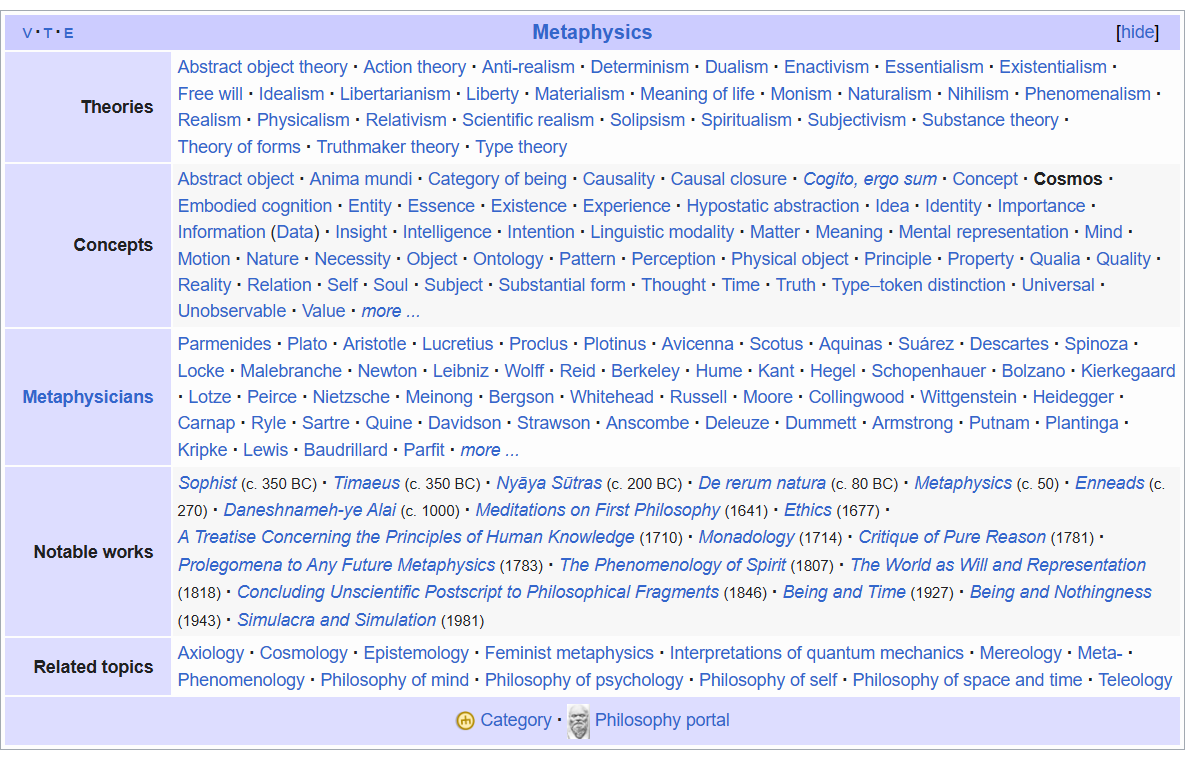

In [70]:
response = qa_chain.invoke("What info is in the table/image talk about?")
print(response)

/tmp/ipykernel_1821/3750515203.py:1: LangChainDeprecationWarning:

The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.



 The table and image discuss Metaphysics, a branch of philosophy that delves into fundamental questions about reality, existence, and the nature of being. It covers various topics such as key theories (like realism and idealism), concepts (such as abstract objects and causality), notable figures (e.g., Plato, Kant), significant works (including "Critique of Pure Reason"), and related fields like philosophy of mind, feminist metaphysics, and more. The table also lists categories within metaphysics (abstract objects, concepts, entities, etc.), as well as metaphysicians (Parmenides, Aristotle, Nietzsche) and notable works in the field (e.g., "Meditations on First Philosophy" by Descartes and "Being and Time" by Heidegger). Additionally, it mentions related topics such as axiology, cosmology, interpretations of quantum mechanics, mereology, and meta-phenomenology. The image text suggests that the ancient Indians believed the universe to be infinite and mapped both the outer world and the i

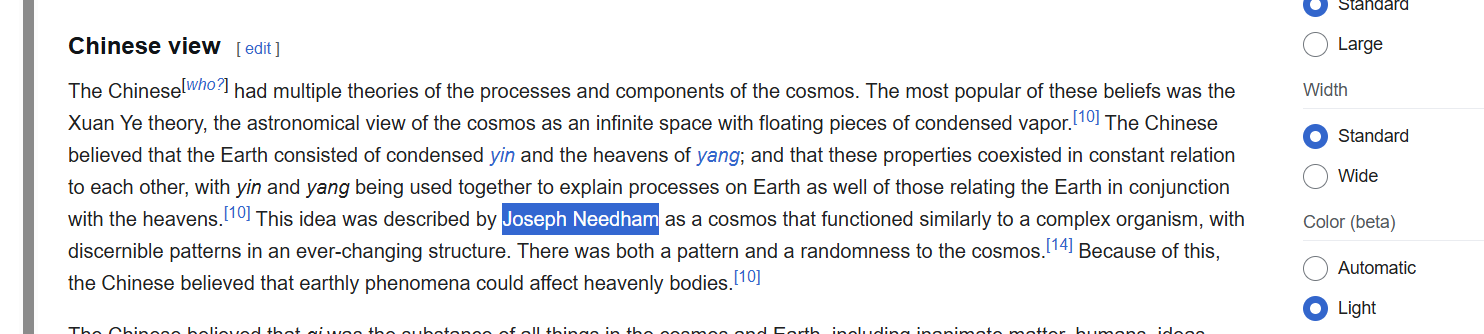

In [71]:
response = qa_chain.invoke("What is chinese view and who is Joseph Needham")

print(response)

{'query': 'What is chinese view and who is Joseph Needham', 'result': ' The Chinese view, as described in Text 27, suggests that the Chinese believed the earth consisted of condensed yin (dark and female) and yang (bright and male), which coexisted in a constant relation. This idea was used to explain processes relating to the earth and its conjunction with the heavens. Joseph Needham is a person mentioned in Text 27, who described this idea. He is known for his works on the history of science and technology in China.'}


In [72]:
response = qa_chain.invoke("detials about Joseph Needham -- everything about him")

print(response)

{'query': 'detials about Joseph Needham -- everything about him', 'result': ' The given text does not provide any details about Joseph Needham. To answer the question about Joseph Needham, you would need to consult a reliable source that provides information about his life, works, and contributions, as he is not mentioned in the provided texts. Joseph Needham was a British historian of science who made significant contributions to the study of Chinese science and technology, especially in the field of Sinology. He was born on March 24, 1903, and died on October 2, 1995. Throughout his career, he published numerous works on various aspects of Chinese history and science, including the famous multi-volume work "Science and Civilisation in China." His works have been influential in promoting a better understanding of Chinese science and culture in the West.'}


In [73]:
from langchain.prompts import PromptTemplate
prompt_template = PromptTemplate(
    input_variables=["context", "question"],
    template="""
You are WebOwl 🦉, a highly precise assistant who chats with users about website content, combining text, table, and image insights from the web.

Context:
{context}

Question:
{question}

Instructions:
- If the user wants a short response, be brief and direct.
- If the user needs a long response or summary, be detailed and clear.
- Mention tables or visual insights if they exist.

Answer:
"""
)


In [74]:

retriever = vectorstore.as_retriever(search_kwargs={"k": 18})

webowl_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=retriever,
    return_source_documents=True,
    chain_type_kwargs={"prompt": prompt_template}
)


In [75]:
response = webowl_chain.invoke("Tell me the exact thing mentioned in the tables or images")

print("🦉 WebOwl Says:\n", response["result"])


/tmp/ipykernel_1821/2311684891.py:1: LangChainDeprecationWarning:

The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.



🦉 WebOwl Says:
 1. The exact things mentioned in these data are:

   - Words "Cosmos" with its etymology (from Greek "κοσμεῖν" meaning generally dispose, prepare especially order arrange) and various meanings across different cultures, including spiritual entities existing outside the physical universe, order or decoration, worldly life, and eternal plane.
   - Concepts related to cosmos such as the celestial bodies observed by ancient societies (including Greeks, Romans, Babylonians, Chinese), complex astronomical understanding, constellations, and the belief that heavenly bodies were made of refined substance called quintessence.
   - The idea of the finite bifurcated cosmos divided into sublunary and superlunary realms, with objects in the lunar disc believed to be stable, and chaotic elements on earth (air, fire, water).
   - Theories related to the nature of the cosmos like Pythagoras' reformer religion, Orphism, and the role of Dionysus; Anaximander as the father of astronomy and